In [1]:
%load_ext tensorboard

In [2]:
import tensorflow as tf 
import numpy as np 
import time
from datetime import datetime
import matplotlib.pyplot as plt
import os 
from IPython import display 

In [3]:
# Load the MNIST dataset 

# Each MNIST image is originally a vector of 784 integers, each of which is between 0-255 and represents the intensity of a pixel. 
# We model each pixel with a Bernoulli distribution in our model, and we statically binarize the dataset.

(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

def preprocess_images(images):
    images = images.reshape((images.shape[0], 28, 28, 1))/255.
    return np.where(images > 0.5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

train_size = 60000
batch_size = 32 
test_size = 10000

In [4]:
# Use tf.data to batch and shuffle the data 
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images).shuffle(test_size).batch(batch_size))

In [5]:
# Define the encoder and deceodr networks with tf.keras.Sequential

# The encoder defines the approximate posterior distribution q(z|x), which takes as input an observation and outputs a set of parameters for specifying 
# the conditional distribution of the latent representation z. In this example, we model the distribution as a diagonal gaussian, and the network outputs the mean 
# and log variance parameters of the factorized gaussian.

# The decoder defines the conditional distribution of the observation p(x|z), which takes a latent sample z as input and outputs the parameters for a conditional 
# distribution of the observation. We model the latent distribution prior as a unit gaussian.

# Reparameterization trick : To generate a sample z for the decoder during training, we can sample from the latent distribution defined by the parameters outputted 
# by the encoder, given an input observation x. However, this sampling operation creates a bottleneck because backpropagation cannot flow through a random node. 
# z = $\mu$ + $\sigma .\epsilon$

In [6]:
class CVAE(tf.keras.Model):
    """ Convolutional Variational Autoencoder"""
    
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
                tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(latent_dim + latent_dim), # No activation
            ]
        )
        
        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim, )),
                tf.keras.layers.Dense(units = 7*7*32, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
                tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'),
                tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
                tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same')
            ]
        )
        
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar


    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps*tf.exp(logvar*0.5) + mean 


    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

![alt text](./VAE_objective.png "VAE Objective/Loss function")

In [7]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2.*np.pi)
    return tf.reduce_sum(-0.5*((sample-mean)**2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)
    
    
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
    """ 
    Executes one training step and returns the loss. This function computes the loss and gradients, and uses the latter to update the model's 
    parameters.
    """
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [8]:
stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join('logs', str(stamp))
writer = tf.summary.create_file_writer(logdir)

In [9]:
epochs = 5 
# set the dimensionality of the latent space to a plane for visualization later 
latent_dim = 2 
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so it will be easier to see the improvement. 
random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [10]:
def generate_and_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(4, 4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i,:,:,0], cmap='gray')
        plt.axis('off')
        
    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [11]:
# Pick a sample of the test set for generating output images 
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 3, Test set ELBO: -166.2913360595703, time elapse for current epoch: 62.85281801223755


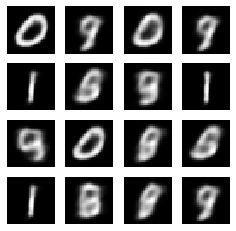

KeyboardInterrupt: 

In [12]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs+1):
    start_time = time.time()
    tf.summary.trace_on(graph=True, profiler=True)
    for train_x in train_dataset:
        train_step(model, train_x, optimizer)
    with writer.as_default():
        tf.summary.trace_export(name='train_step_trace', step=0, profiler_outdir=logdir)
    end_time = time.time()
    
    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        loss(compute_loss(model, test_x))
    elbo = -loss.result()
    display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'.format(epoch, elbo, end_time-start_time))
    generate_and_save_images(model, epoch, test_sample)

In [14]:
%tensorboard --logdir logs

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 24116.